# Ensemble-Volatility

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# List of Stocks and ETFs
Provided by Thomas Choi.

In [2]:
stock_list = pd.read_csv("../stocks_and_etfs/stock_list.csv")
etf_list = pd.read_csv("../stocks_and_etfs/etf_list.csv")

In [3]:
import random

# Choose a random stock
stock_symbol = random.choice(stock_list.iloc[:,0])
print(stock_symbol)

HPQ


## MySQL connection
Choosing one stock from SQL query to reduce query time.

In [4]:
# Environment variables
from dotenv import load_dotenv
load_dotenv("../mysql.env")

import os
import sys
import mysql.connector

HOST=os.environ.get("HOST")
PORT=os.environ.get("PORT")
USER=os.environ.get("USER")
PASSWORD=os.environ.get("PASSWORD")

try: 
    conn = mysql.connector.connect(
        host=HOST,
        port=PORT,
        user=USER,
        password=PASSWORD,
        database="GlobalMarketData"
    )
    query = f"SELECT Date, Close, Open, High, Low, Volume from histdailyprice3 WHERE Symbol='{stock_symbol}';"
    histdailyprice3 = pd.read_sql(query, conn)
    conn.close()
except Exception as e:
    conn.close()
    print(str(e))

# Data

In [5]:
df = histdailyprice3.copy()

In [6]:
returns = 100 * df['Close'].pct_change().dropna()
realized_vol = returns.rolling(5).std()

In [7]:
n = int(len(returns)*0.4)
split_date = returns[-n:].index

# ARCH

In [16]:
from arch import arch_model
model = arch_model(returns, mean='Zero', vol='ARCH', p=1, o=0, q=0)
model_fitted = model.fit(disp='off')
print(model_fitted.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -13911.9
Distribution:                  Normal   AIC:                           27827.9
Method:            Maximum Likelihood   BIC:                           27841.3
                                        No. Observations:                 6176
Date:                Tue, Jan 04 2022   Df Residuals:                     6176
Time:                        08:44:44   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          4.1762      0.241     17.336  2.518e-67 [  3.704,  4.64

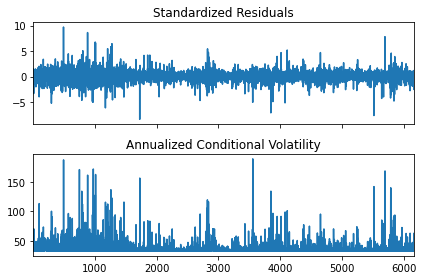

In [10]:
model_fitted.plot(annualize='D')

plt.tight_layout()
plt.show()

In [12]:
model = arch_model(returns, mean='Zero', vol='ARCH', p=1, o=0, q=0)
model_fit = model.fit(disp='off')
pred = model_fit.forecast(horizon=1)

## Tuning Parameters
Bayesian Information Criteria (BIC) as the model selection method and to select lag.

In [13]:
bic_arch = []

for p in range(1, 5):
    arch = arch_model(returns, mean='zero', vol='ARCH', p=p).fit(disp='off')
    bic_arch.append(arch.bic)
    if arch.bic == np.min(bic_arch):
         best_param = p
arch = arch_model(returns, mean='zero', vol='ARCH', p=best_param).fit(disp='off')
print(arch.summary())
forecast = arch.forecast(start=split_date[0])
forecast_arch = forecast

                        Zero Mean - ARCH Model Results                        
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -13734.4
Distribution:                  Normal   AIC:                           27478.8
Method:            Maximum Likelihood   BIC:                           27512.4
                                        No. Observations:                 6176
Date:                Tue, Jan 04 2022   Df Residuals:                     6176
Time:                        08:42:56   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          2.6225      0.269      9.738  2.069e-22   [  2.09

In [14]:
from sklearn.metrics import mean_squared_error as mse

forecast_arch.variance

,h.1
1,NaN
2,NaN
3,NaN
4,NaN
5,NaN
...,...
6172,14.738364
6173,11.756792
6174,11.560082
6175,7.181089


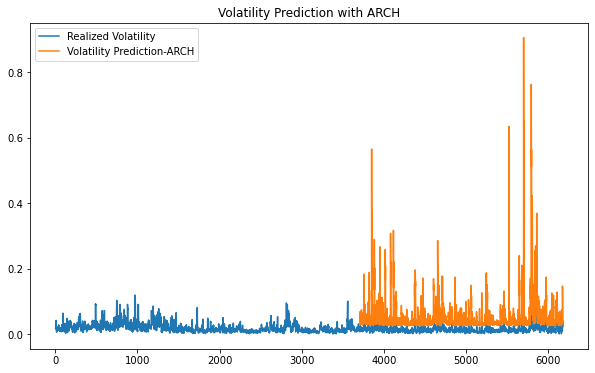

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_arch.variance.iloc[-len(split_date):] / 100, label='Volatility Prediction-ARCH')
plt.title('Volatility Prediction with ARCH', fontsize=12)
plt.legend()
plt.show()

## GARCH

In [18]:
garch = arch_model(returns, mean='zero', vol='GARCH', p=1, o=0, q=1).fit(disp='off')
print(garch.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -13563.0
Distribution:                  Normal   AIC:                           27131.9
Method:            Maximum Likelihood   BIC:                           27152.1
                                        No. Observations:                 6176
Date:                Tue, Jan 04 2022   Df Residuals:                     6176
Time:                        08:45:15   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.0892  6.989e-02      1.276      0.202 [-4.77

## Tuning parameters

In [24]:
bic_garch = []

for p in range(1, 5):
    for q in range(1, 5):
        garch = arch_model(returns, mean='zero', vol='GARCH', p=p, o=0, q=q).fit(disp='off')
        bic_garch.append(garch.bic)
        if garch.bic == np.min(bic_garch):
            best_param = p, q
garch = arch_model(returns, mean='zero', vol='GARCH',
                p=best_param[0], o=0, q=best_param[1]).fit(disp='off')
print(garch.summary())
forecast = garch.forecast(start=split_date[0])
forecast_garch = forecast

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -13512.4
Distribution:                  Normal   AIC:                           27036.8
Method:            Maximum Likelihood   BIC:                           27077.1
                                        No. Observations:                 6176
Date:                Tue, Jan 04 2022   Df Residuals:                     6176
Time:                        08:48:20   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1490  6.700e-02      2.224  2.615e-02 [1.769e-0

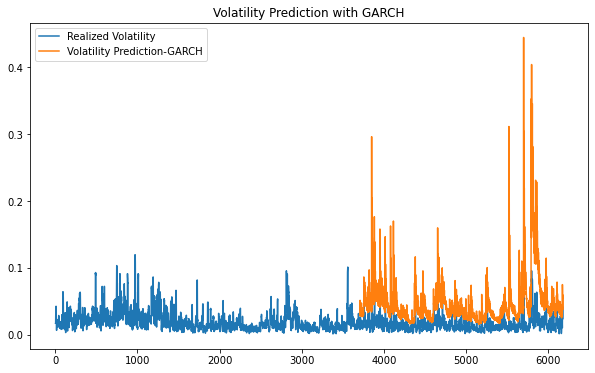

In [22]:
plt.figure(figsize=(10,6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_garch.variance.iloc[-len(split_date):] / 100, label='Volatility Prediction-GARCH')
plt.title('Volatility Prediction with GARCH', fontsize=12)
plt.legend()
plt.show()

## GJR GARCH

In [27]:
bic_gjr_garch = []

for p in range(1, 5):
    for q in range(1, 5):
        gjrgarch = arch_model(returns, mean='zero', p=p, o=1, q=q).fit(disp='off')
        bic_gjr_garch.append(gjrgarch.bic)
        if gjrgarch.bic == np.min(bic_gjr_garch):
             best_param = p, q
gjrgarch = arch_model(returns, mean='zero', p=best_param[0], o=1, q=best_param[1]).fit(disp='off')
print(gjrgarch.summary())
forecast = gjrgarch.forecast(start=split_date[0])
forecast_gjrgarch = forecast

bic_garch = []

                     Zero Mean - GJR-GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -13482.7
Distribution:                  Normal   AIC:                           26979.3
Method:            Maximum Likelihood   BIC:                           27026.4
                                        No. Observations:                 6176
Date:                Tue, Jan 04 2022   Df Residuals:                     6176
Time:                        08:51:51   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1437  5.863e-02      2.450  1.427e-02 [2.876e-0

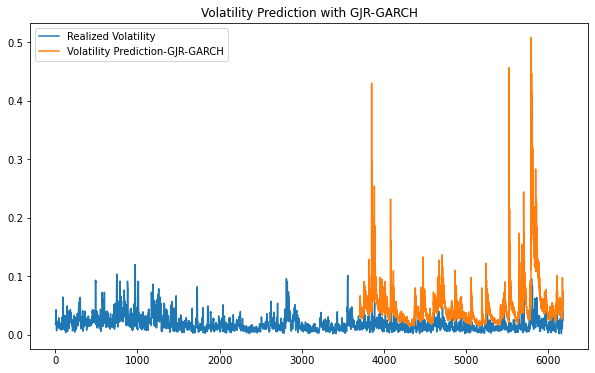

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_gjrgarch.variance.iloc[-len(split_date):] / 100, label='Volatility Prediction-GJR-GARCH')
plt.title('Volatility Prediction with GJR-GARCH', fontsize=12)
plt.legend()
plt.show()